# 08 - Evaluation on Test-Shift with Threshold-Only Adaptation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/08_evaluation_shifted_threshold_only.ipynb)

**Phase 6.2: Threshold-Only Adaptation**

This notebook implements an ablation study to isolate the contribution of **threshold recalibration** from full model adaptation.

**Experimental Setup:**
- Models: Trained on Clean data (NO retraining)
- Thresholds: RE-calibrated on Val-shift (F1-optimal)
- Test: Evaluated on Test-shift

**Goal:**
Measure how much performance can be recovered through threshold adaptation alone, without model retraining.

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)

## 1. Setup & Configuration

In [12]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories on Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PATCHCORE_MODELS_DIR = DRIVE_ROOT / '04_patchcore_clean_outputs'
PADIM_MODELS_DIR = DRIVE_ROOT / '05_padim_clean_outputs'

RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shift_threshold_only'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_shifted folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print("\n" + "="*70)
print("SETUP COMPLETE")
print("="*70)
print(f"Project:   {PROJECT_ROOT}")
print(f"Dataset:   {DATASET_PATH}")
print(f"PatchCore: {PATCHCORE_MODELS_DIR}")
print(f"PaDiM:     {PADIM_MODELS_DIR}")
print(f"Results:   {RESULTS_DIR}")
print(f"Viz:       {VIZ_DIR}")
print("="*70)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done!

Cloning repository (branch: main)...
Removing existing repository...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 759 (delta 131), reused 159 (delta 56), pack-reused 477 (from 1)
Receiving objects: 100% (759/759), 195.57 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (411/411), done.
Updating files: 100% (89/89), done.
Done!


SETUP COMPLETE
Project:   /content/Detection-of-Anomalies-with-Localization
Dataset:   /content/drive/MyDrive/mvtec_shifted
PatchCore: /content/drive/MyDrive/anomaly_detection_project/04_patchcore_clean_outputs
PaDiM:     /content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs
Results:   /content/Detection-of-Anomal

Install both `faiss` and `anomalib` libraries, required for running PatchCore and PaDiM models respectively. **Must be done before any imports.**

In [13]:
!pip install faiss-cpu --quiet
!pip install anomalib --quiet

Import necessary libraries and modules.

In [14]:
# Standard imports
import json
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to evaluate
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def evaluation_collate(batch):
    """Custom collate function to handle None masks in batches."""
    batch = list(zip(*batch))
    images = torch.stack(batch[0])
    masks = batch[1] # Keep as tuple/list to handle None
    labels = torch.tensor(batch[2])
    paths = batch[3]
    return images, masks, labels, paths

print(f"Using device: {DEVICE}")
print(f"Classes: {CLASSES}")

Random seed set to 42 for reproducibility
Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Using device: cpu
Classes: ['hazelnut', 'carpet', 'zipper']


## 2. Load Shifted Data Splits

In [15]:
# Load shifted splits
SPLITS_PATH = paths.get_split_path('shifted')
splits = load_splits(SPLITS_PATH)

# Print split statistics
print("\nSplit Statistics:")
print("-" * 50)
for class_name in CLASSES:
    val_n = len(splits[class_name]['val']['images'])
    test_n = len(splits[class_name]['test']['images'])

    val_normal = sum(1 for l in splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Val: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test: {test_n} ({test_normal} normal, {test_anom} anomalous)")


Split Statistics:
--------------------------------------------------
hazelnut:
  Val: 100 (79 normal, 21 anomalous)
  Test: 89 (40 normal, 49 anomalous)
carpet:
  Val: 82 (56 normal, 26 anomalous)
  Test: 91 (28 normal, 63 anomalous)
zipper:
  Val: 83 (48 normal, 35 anomalous)
  Test: 116 (32 normal, 84 anomalous)


## 3. Threshold Calibration on Val-Shift

**CRITICAL STEP:** We recalibrate thresholds using predictions from **clean-trained models** on **Val-shift** data.

This isolates the effect of threshold adaptation from model adaptation.

In [16]:
# Initialize threshold calibrators
patchcore_calibrator = ThresholdCalibrator('patchcore')
padim_calibrator = ThresholdCalibrator('padim')

# Get transforms
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Store calibration data for visualization
calibration_data = {
    'patchcore': {},
    'padim': {}
}

print("=" * 60)
print("THRESHOLD CALIBRATION (F1-Optimal on Val-shift)")
print("=" * 60)

THRESHOLD CALIBRATION (F1-Optimal on Val-shift)


In [17]:
# PATCHCORE: Calibrate thresholds on Val-shift
print("\n>>> PATCHCORE <<<\n")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create validation dataset
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions on VAL-SHIFT
    val_scores = []
    val_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f'Validating {class_name}'):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=False)

            val_scores.extend(scores.tolist())
            val_labels.extend(labels.numpy().tolist())

    # Convert to arrays
    val_scores = np.array(val_scores)
    val_labels = np.array(val_labels)

    # Calibrate threshold on Val-shift
    threshold = patchcore_calibrator.calibrate(class_name, val_scores, val_labels)
    print(f"  Calibrated threshold: {threshold:.4f}")

    # Store for visualization
    calibration_data['patchcore'][class_name] = {
        'scores': val_scores,
        'labels': val_labels,
        'threshold': threshold
    }

# Save calibrated thresholds
patchcore_calibrator.save(THRESHOLDS_DIR / 'shift_threshold_only_patchcore.json')
print(f"\n[OK] Thresholds saved: shift_threshold_only_patchcore.json")


>>> PATCHCORE <<<


--- HAZELNUT ---
✓ Using FAISS for fast k-NN search (memory bank: 12230 samples, 1536 dims)


Validating hazelnut:   0%|          | 0/13 [00:00<?, ?it/s]

  Calibrated threshold: 1627.0023

--- CARPET ---
✓ Using FAISS for fast k-NN search (memory bank: 8780 samples, 1536 dims)


Validating carpet:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 1522.3188

--- ZIPPER ---
✓ Using FAISS for fast k-NN search (memory bank: 7526 samples, 1536 dims)


Validating zipper:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 1551.3514
[OK] Thresholds saved: shift_threshold_only_patchcore.json

[OK] Thresholds saved: shift_threshold_only_patchcore.json


In [18]:
# PADIM: Calibrate thresholds on Val-shift
print("\n>>> PADIM <<<\n")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create validation dataset
    val_split = splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions on VAL-SHIFT
    val_scores = []
    val_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f'Validating {class_name}'):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=False)

            val_scores.extend(scores.tolist())
            val_labels.extend(labels.numpy().tolist())

    # Convert to arrays
    val_scores = np.array(val_scores)
    val_labels = np.array(val_labels)

    # Calibrate threshold on Val-shift
    threshold = padim_calibrator.calibrate(class_name, val_scores, val_labels)
    print(f"  Calibrated threshold: {threshold:.4f}")

    # Store for visualization
    calibration_data['padim'][class_name] = {
        'scores': val_scores,
        'labels': val_labels,
        'threshold': threshold
    }

# Save calibrated thresholds
padim_calibrator.save(THRESHOLDS_DIR / 'shift_threshold_only_padim.json')
print(f"\n[OK] Thresholds saved: shift_threshold_only_padim.json")


>>> PADIM <<<


--- HAZELNUT ---
[OK] Model loaded: padim_hazelnut_clean.pt


Validating hazelnut:   0%|          | 0/13 [00:00<?, ?it/s]

  Calibrated threshold: 56.2653

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Validating carpet:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 42.6108

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Validating zipper:   0%|          | 0/11 [00:00<?, ?it/s]

  Calibrated threshold: 92.3710
[OK] Thresholds saved: shift_threshold_only_padim.json

[OK] Thresholds saved: shift_threshold_only_padim.json


## 4. Visualization: Score Distributions & Thresholds

Visualizing how anomaly scores are distributed on Val-shifted data and where the new thresholds fall.

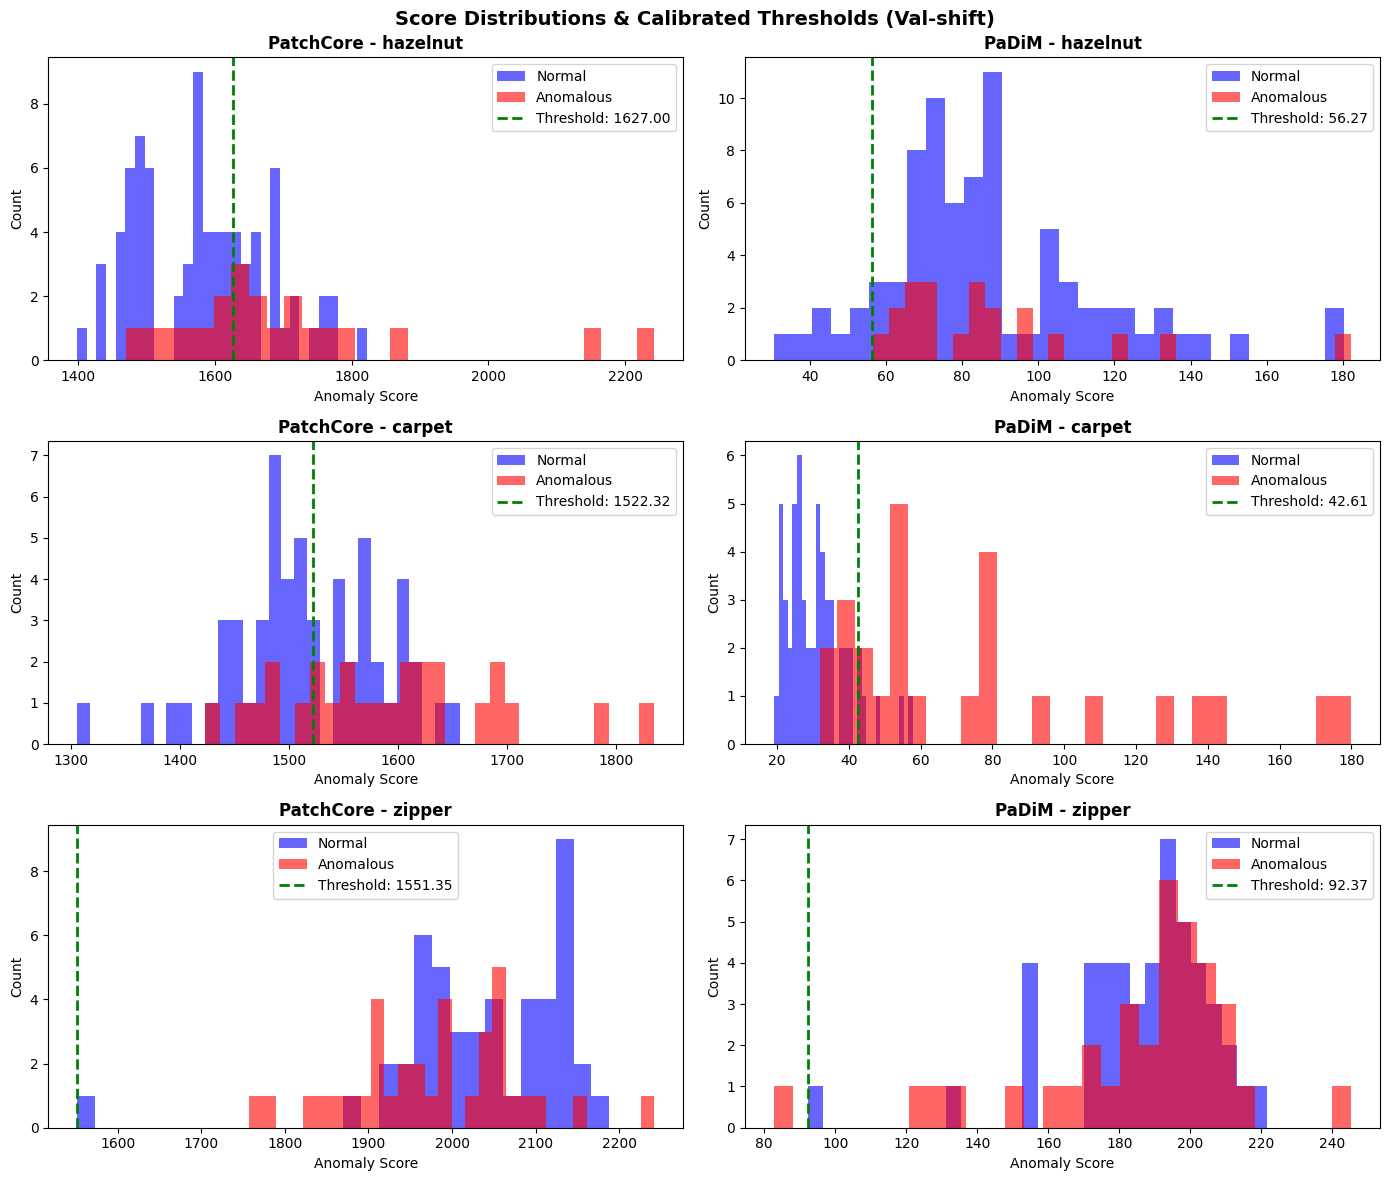

In [19]:
# Visualization: Score distributions and thresholds
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score')
    ax1.set_ylabel('Count')
    ax1.legend()

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Count')
    ax2.legend()

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-shift)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'score_distributions_shift_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Evaluation on Test-Shift with Recalibrated Thresholds

Now we evaluate on the test set using the **recalibrated thresholds from Val-shift**.

In [20]:
# Load recalibrated thresholds from saved results
thresholds = {
    'patchcore': patchcore_calibrator.thresholds,
    'padim': padim_calibrator.thresholds
}

# Storage for results
all_results = {
    'patchcore': {},
    'padim': {}
}

In [21]:
# PATCHCORE: Evaluate on Test-shift
print("\n" + "="*60)
print("TEST-SHIFT EVALUATION (PATCHCORE)")
print("="*60)

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get recalibrated threshold
    threshold = thresholds['patchcore'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['patchcore'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (recalibrated on val-shift): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


TEST-SHIFT EVALUATION (PATCHCORE)

--- HAZELNUT ---
✓ Using FAISS for fast k-NN search (memory bank: 12230 samples, 1536 dims)


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 1627.0023
  AUROC: 0.7704
  AUPRC: 0.8233
  F1: 0.6813
  Accuracy: 0.6742
  Pixel AUROC: 0.8350382790082641
  PRO: 0.7066494324737501

--- CARPET ---
✓ Using FAISS for fast k-NN search (memory bank: 8780 samples, 1536 dims)


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 1522.3188
  AUROC: 0.7874
  AUPRC: 0.9019
  F1: 0.7568
  Accuracy: 0.7033
  Pixel AUROC: 0.7455580742441463
  PRO: 0.40766846847606253

--- ZIPPER ---
✓ Using FAISS for fast k-NN search (memory bank: 7526 samples, 1536 dims)


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 1551.3514
  AUROC: 0.3564
  AUPRC: 0.6692
  F1: 0.8400
  Accuracy: 0.7241
  Pixel AUROC: 0.7516269771283969
  PRO: 0.3725530579958771


In [22]:
# PADIM: Evaluate on Test-shift
print("\n" + "="*60)
print("TEST-SHIFT EVALUATION (PADIM)")
print("="*60)

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        collate_fn=evaluation_collate
    )

    # Load model trained on CLEAN data
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get recalibrated threshold
    threshold = thresholds['padim'][class_name]

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['padim'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold (recalibrated on val-shift): {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics.get('accuracy', 'N/A'):.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


TEST-SHIFT EVALUATION (PADIM)

--- HAZELNUT ---
[OK] Model loaded: padim_hazelnut_clean.pt


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 56.2653
  AUROC: 0.6041
  AUPRC: 0.6600
  F1: 0.7111
  Accuracy: 0.5618
  Pixel AUROC: 0.7995458677412346
  PRO: 0.5277786771421755

--- CARPET ---
[OK] Model loaded: padim_carpet_clean.pt


Testing carpet:   0%|          | 0/12 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 42.6108
  AUROC: 0.8940
  AUPRC: 0.9559
  F1: 0.8496
  Accuracy: 0.8132
  Pixel AUROC: 0.9546021057389024
  PRO: 0.7374670725809731

--- ZIPPER ---
[OK] Model loaded: padim_zipper_clean.pt


Testing zipper:   0%|          | 0/15 [00:00<?, ?it/s]

  Threshold (recalibrated on val-shift): 92.3710
  AUROC: 0.5525
  AUPRC: 0.7828
  F1: 0.8400
  Accuracy: 0.7241
  Pixel AUROC: 0.7258757410365235
  PRO: 0.3235764135316969


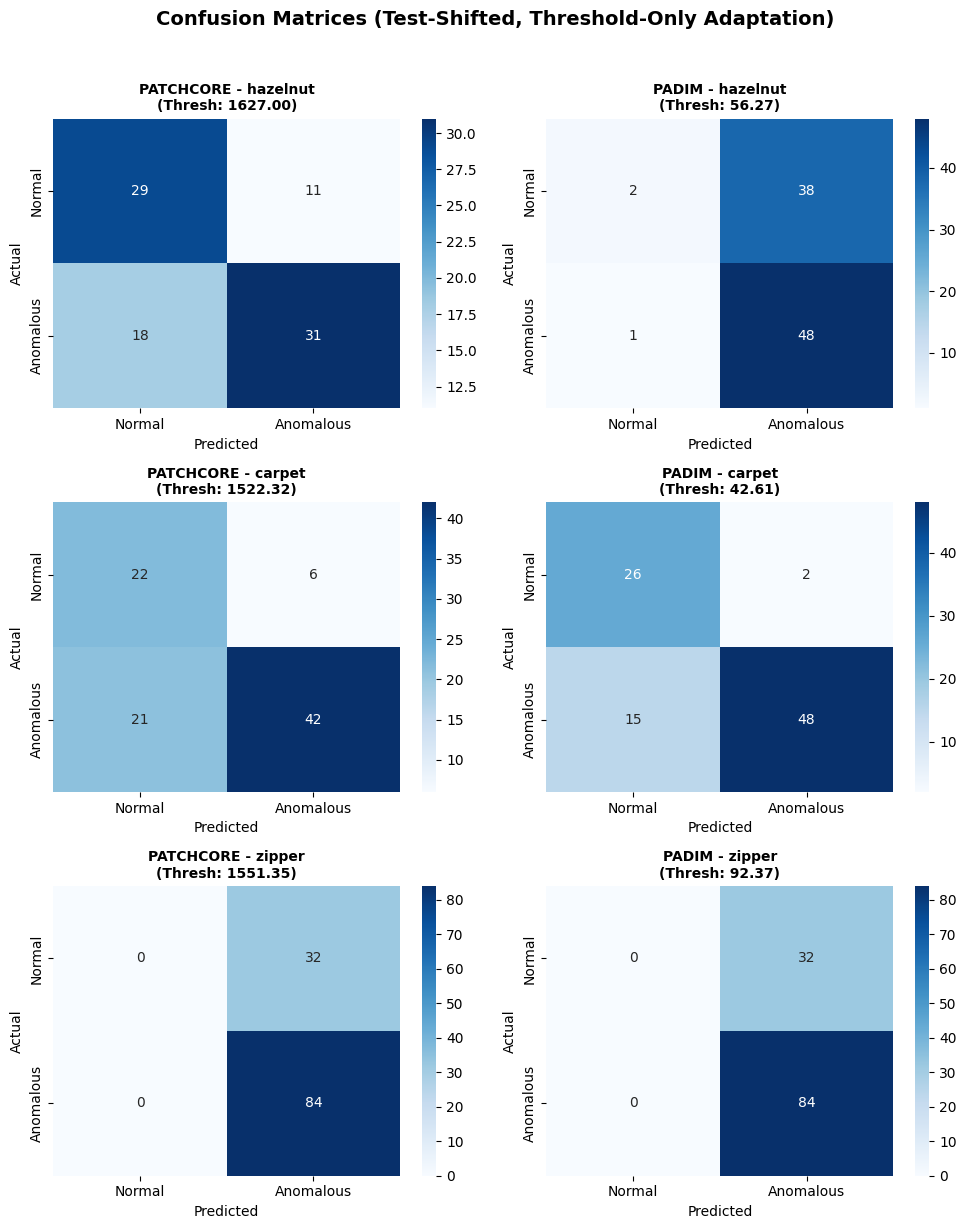

In [25]:
# Confusion Matrices (Test-Shifted, Threshold-Only Adaptation)
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(labels, scores, threshold):
    preds = (scores >= threshold).astype(int)
    return confusion_matrix(labels, preds)

fig, axes = plt.subplots(len(CLASSES), 2, figsize=(10, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    for j, method in enumerate(['patchcore', 'padim']):
        ax = axes[i, j]

        # Recupera i risultati salvati nel dizionario all_results
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])
        # Qui usiamo la threshold ricalibrata salvata per questa fase
        threshold = all_results[method][class_name]['threshold']

        cm = compute_confusion_matrix(labels, scores, threshold)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomalous'],
                    yticklabels=['Normal', 'Anomalous'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{method.upper()} - {class_name}\n(Thresh: {threshold:.2f})', fontsize=10, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-Shifted, Threshold-Only Adaptation)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrices_shifted_threshold_only.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results & Copy to Drive

In [28]:
# Helper to convert results for JSON serialization
def convert_for_json(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(i) for i in obj]
    else:
        return obj

# Save full results JSON
json_path = RESULTS_DIR / 'shifted_threshold_only_results.json'
with open(json_path, 'w') as f:
    json.dump(convert_for_json(all_results), f, indent=2)
print(f"[OK] Results saved: {json_path.name}")

# Create summary CSV
import pandas as pd
summary_rows = []

for method, method_results in all_results.items():
    for class_name, res in method_results.items():
        row = {
            'Method': method.upper(),
            'Class': class_name,
            'Threshold': res['threshold'],
            'AUROC': res['image_level']['auroc'],
            'AUPRC': res['image_level']['auprc'],
            'F1': res['image_level']['f1'],
            'Accuracy': res['image_level']['accuracy'],
            'Pixel AUROC': res['pixel_level']['pixel_auroc'],
            'PRO': res['pixel_level']['pro']
        }
        summary_rows.append(row)

# Create DataFrame
df = pd.DataFrame(summary_rows)

# Add Macro Average
for method in ['PATCHCORE', 'PADIM']:
    method_df = df[df['Method'] == method]
    if not method_df.empty:
        macro_avg = method_df.mean(numeric_only=True)
        macro_row = macro_avg.to_dict()
        macro_row['Method'] = method
        macro_row['Class'] = 'Macro_average'
        summary_rows.append(macro_row)

final_df = pd.DataFrame(summary_rows)
csv_path = RESULTS_DIR / 'shifted_threshold_only_results_summary.csv'
final_df.to_csv(csv_path, index=False)
print(f"[OK] Summary saved: {csv_path.name}")

print("\n" + "="*60)
print("SUMMARY RESULTS (Threshold-Only Adaptation)")
print("="*60)
print(final_df[['Method', 'Class', 'AUROC', 'F1', 'Pixel AUROC', 'PRO']].to_string(index=False))

[OK] Results saved: shifted_threshold_only_results.json
[OK] Summary saved: shifted_threshold_only_results_summary.csv

SUMMARY RESULTS (Threshold-Only Adaptation)
   Method         Class    AUROC       F1  Pixel AUROC      PRO
PATCHCORE      hazelnut 0.770408 0.681319     0.835038 0.706649
PATCHCORE        carpet 0.787415 0.756757     0.745558 0.407668
PATCHCORE        zipper 0.356399 0.840000     0.751627 0.372553
    PADIM      hazelnut 0.604082 0.711111     0.799546 0.527779
    PADIM        carpet 0.893991 0.849558     0.954602 0.737467
    PADIM        zipper 0.552455 0.840000     0.725876 0.323576
PATCHCORE Macro_average 0.638074 0.759358     0.777408 0.495624
    PADIM Macro_average 0.683509 0.800223     0.826675 0.529607


In [29]:
# Copy Results to Drive for persistence

# Create destination folders
THRESHOLD_ONLY_OUTPUTS = DRIVE_ROOT / '08_threshold_only_outputs'
THRESHOLD_ONLY_OUTPUTS.mkdir(parents=True, exist_ok=True)

import shutil

generated_files = [
    THRESHOLDS_DIR / 'shift_threshold_only_patchcore.json',
    THRESHOLDS_DIR / 'shift_threshold_only_padim.json',
    RESULTS_DIR / 'shifted_threshold_only_results.json',
    RESULTS_DIR / 'shifted_threshold_only_results_summary.csv',
    VIZ_DIR / 'score_distributions_shift_threshold.png'
]

print("\nCopying files to Drive...")
for src in generated_files:
    if src.exists():
        dst = THRESHOLD_ONLY_OUTPUTS / src.name
        shutil.copy(src, dst)
        print(f"  [COPIED] {src.name}")
    else:
        print(f"  [MISSING] {src.name}")

print(f"\nAll results saved to: {THRESHOLD_ONLY_OUTPUTS}")


Copying files to Drive...
  [COPIED] shift_threshold_only_patchcore.json
  [COPIED] shift_threshold_only_padim.json
  [COPIED] shifted_threshold_only_results.json
  [COPIED] shifted_threshold_only_results_summary.csv
  [COPIED] score_distributions_shift_threshold.png

All results saved to: /content/drive/MyDrive/anomaly_detection_project/08_threshold_only_outputs
